In [1]:
# This generates configuration values with Capytaine.

#!pip install capytaine #uncomment if first time running

import capytaine as cpt
import numpy as np
import matplotlib.pyplot as plt
from capytaine.bem.airy_waves import airy_waves_potential, airy_waves_velocity, froude_krylov_force
import time

import os
import sys

In [2]:
def save_potential_array(title, arr):
    file_path = "data/" + title + "-real" + ".csv"
    np.savetxt(file_path, np.real(arr), delimiter=",", fmt="%.6e")
    file_path = "data/" + title + "-imag" + ".csv"
    np.savetxt(file_path, np.imag(arr), delimiter=",", fmt="%.6e")

# use to get rid of prints
def deafen(function, *args):
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args)
    sys.stdout = real_stdout
    return output

In [3]:
solver = cpt.BEMSolver()

def timed_solve(problem, reps):
    t_lst = []
    for i in range(reps):
        t0 = time.perf_counter()
        result = solver.solve(problem, keep_details = True)
        t1 = time.perf_counter()
        t_lst.append(t1 - t0)
    tdiff = sum(t_lst)/reps
    return result, tdiff

def get_points(a, d): # These points define the outline of the body
    d_prime = d + [0]
    d_index = 0
    a_index = 0
    pt_lst = [(0, - d[0])]
    for i in range(len(a)):
        pt_lst.append((a[a_index], - d_prime[d_index]))
        d_index +=1
        pt_lst.append((a[a_index], - d_prime[d_index]))
        a_index+=1
    return pt_lst

# compute number of panels along each surface given total number along the outline
def get_f_densities(pt_lst, total_units):
    face_lengths = np.array([])
    for i in range(len(pt_lst) - 1):
        p1, p2 = pt_lst[i], pt_lst[i + 1]
        face_length = abs(p2[0] - p1[0]) + abs(p2[1] - p1[1]) # one of these two values will be zero
        face_lengths = np.append(face_lengths, face_length)
    total_length = sum(face_lengths)
    each_face_densities = np.vectorize(lambda x: max(1, x/total_length * total_units))(face_lengths) # each face needs at least one panel
    remainders = each_face_densities % 1
    each_face_densities = each_face_densities.astype(int)
    remaining_units = total_units - sum(each_face_densities)
    if remaining_units < 0: # high proportion of small faces
        for u in range(remaining_units * -1):
            i = np.argmax(each_face_densities) # cut density from the largest faces
            each_face_densities[i] = (each_face_densities[i]) - 1
    else:
        for u in range(remaining_units): # distribute remaining units where most needed
            i = np.argmax(remainders)
            each_face_densities[i] = (each_face_densities[i]) + 1
            remainders[i] = 0
    assert sum(each_face_densities) == total_units
    return each_face_densities

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heaving, region, p1, p2, f_density, t_density, meshes, mask, panel_ct):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heaving[region]:
        direction = [0, 0, 1]
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels)

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct = 0
    mask = []
    for i in range((len(pts) - 1) // 2):
        p1, p2, p3 = pts[2 * i], pts[2 * i + 1], pts[2 * i + 2]
        # make a horizontal face
        meshes, mask, panel_ct = faces_and_heaves(heaving, i, p1, p2, f_densities[2 * i], t_densities[i], meshes, mask, panel_ct)
        # make a vertical face
        if p2[1] < p3[1]: # body on left
            region = i
        else: # body on right
            region = i + 1
        meshes, mask, panel_ct = faces_and_heaves(heaving, region, p2, p3, f_densities[2 * i + 1], t_densities[region], meshes, mask, panel_ct)
    body = deafen(cpt.FloatingBody, meshes) # unclosed boundary warnings
    return body, panel_ct, mask

def construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps):
    pt_lst = get_points(a, d)
    f_densities = get_f_densities(pt_lst, face_units)
    
    body, panel_count, mask = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    body.show_matplotlib()
    
    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    solver = cpt.BEMSolver()
    result, t_diff = timed_solve(rad_problem, reps)

    diff_problem = cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    result_d, t_diff_d = timed_solve(diff_problem, reps)

    print("Panel Count: ", panel_count)
    print(result.added_mass)
    print(result.radiation_damping)
    print("Solve Time (Radiation): ", t_diff)
    print("Solve Time (Diffraction): ", t_diff_d)
    print("Excitation Phase: ", get_excitation_phase(result_d))
    return result, t_diff, result_d, t_diff_d, panel_count

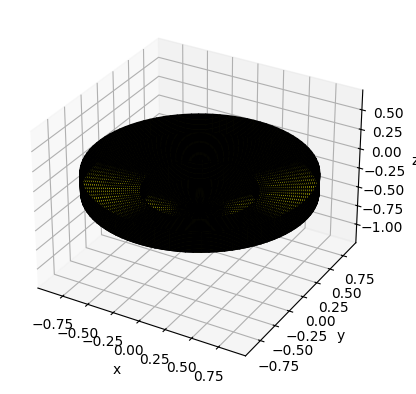

Panel Count:  6750
{'Heave': 1586.2410564342385}
{'Heave': 3186.3017275343254}
Solve Time (Radiation):  56.05556566599989
Solve Time (Diffraction):  0.08915816701482981
Excitation Phase:  -0.5194497776393395


In [4]:
# original - two cylinder
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [1, 1]
t_densities = [50, 100] # number of panels around each cylinder
face_units = 90 # number of panels along the outline of the configuration
m0 = 1
rho = 1023 # density of our special material
config = "config0"
reps = 1 # 1st solve always significantly longer than others

result_r, solve_time_r, result_d, solve_time_d, panel_count_alt = construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps)

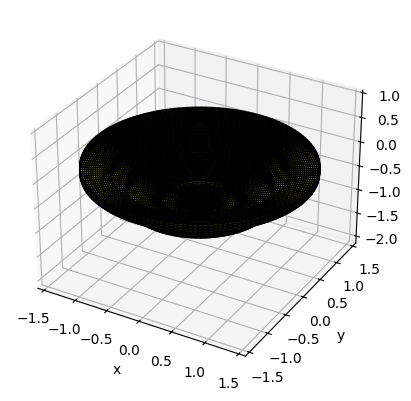

Panel Count:  8930
{'Heave': 4739.441619430274}
{'Heave': 11662.810903111465}
Solve Time (Radiation):  146.99396358401282
Solve Time (Diffraction):  0.1805250830075238
Excitation Phase:  -1.0626678333131123


In [5]:
#staircase  - compound cylinder
h = 1.5
d = [1.1, 0.85, 0.75, 0.4, 0.15]
a = [0.3, 0.5, 1, 1.2, 1.6]
heaving = [1, 1, 1, 1, 1]
t_densities = [30, 50, 100, 120, 160]
face_units = 93
m0 = 1
rho = 1023
config = "config1"
reps = 1

result_r, solve_time_r, result_d, solve_time_d, panel_count_alt = construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps)

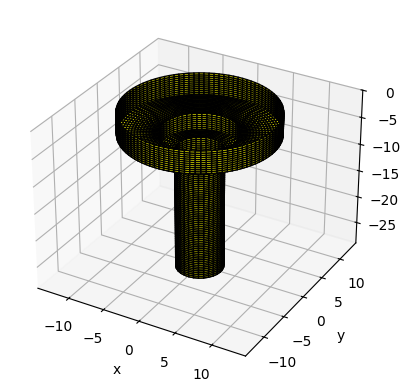

[15:22:03] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="collection_of_meshes_28"), wavenumber=1.000, water_depth=100.0, radiating_dof='Heave',   
                    rho=1023.0):                                                                                   
                    The body FloatingBody(..., name="collection_of_meshes_28") might display irregular frequencies 
                    for wavenumber=1.                                                                              
                    Setting a lid for the floating body is recommended.

[15:22:35] WARNING  Irregular frequencies for DiffractionProblem(body=FloatingBody(...,                            
                    name="collection_of_meshes_28"), wavenumber=1.000, water_depth=100.0, wave_direction=0.000,    
                    rho=1023.0):                                                                                   
                    The body FloatingBody(..., name="collection_of_meshes_28") might display irregular frequencies 
                    for wavenumber=1.                                                                              
                    Setting a lid for the floating body is recommended.

Panel Count:  5330
{'Heave': 1341745.8381018587}
{'Heave': 222.1023180983429}
Solve Time (Radiation):  31.674926709005376
Solve Time (Diffraction):  0.06724579198635183
Excitation Phase:  -2.963436544344762


In [6]:
#tall  - compound cylinder
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [1, 1, 1]
t_densities = [30, 50, 100]
face_units = 110
m0 = 1
rho = 1023
config = "config2"
reps = 1

result_r, solve_time_r, result_d, solve_time_d, panel_count_alt = construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps)

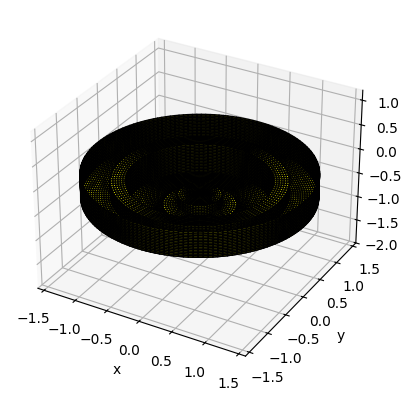

Panel Count:  11660
{'Heave': 5881.6050262025565}
{'Heave': 6875.158124571653}
Solve Time (Radiation):  170.15780250000535
Solve Time (Diffraction):  0.3370624579838477
Excitation Phase:  -1.0437407701107935


In [7]:
#indents  - compound cylinder
h = 1.9
d = [0.5, 0.7, 0.8, 0.2, 0.5]
a = [0.3, 0.5, 1, 1.2, 1.6]
heaving = [1, 1, 1, 1, 1]
t_densities = [30, 50, 100, 120, 160]
face_units = 105
m0 = 1
rho = 1023
config = "config3"
reps = 1

result_r, solve_time_r, result_d, solve_time_d, panel_count_alt = construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps)

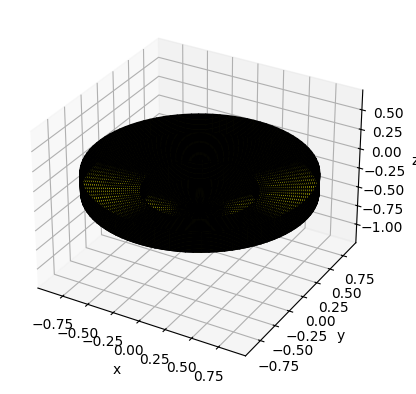

Panel Count:  6750
{'Heave': 924.6499405282137}
{'Heave': 1835.453237409865}
Solve Time (Radiation):  54.50835541600827
Solve Time (Diffraction):  0.09106395798153244
Excitation Phase:  -0.5194543676491261


In [8]:
#original - only outer heaving
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [0, 1]
t_densities = [50, 100]
face_units = 90
m0 = 1
rho = 1023
config = "config4"
reps = 1

result_r, solve_time_r, result_d, solve_time_d, panel_count_alt = construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps)

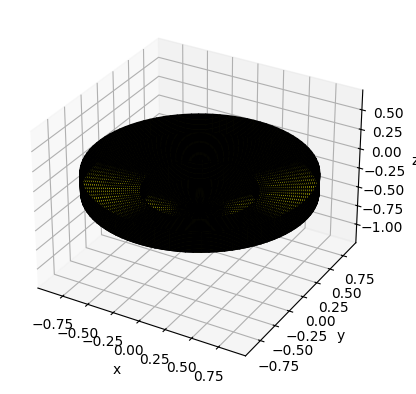

Panel Count:  6750
{'Heave': 286.15543998913375}
{'Heave': 185.08145074428117}
Solve Time (Radiation):  0.470053333992837
Solve Time (Diffraction):  0.3286764999793377
Excitation Phase:  -0.5194353495383882


In [9]:
#original - only inner heaving
h = 1.001
d = [0.5, 0.25]
a = [0.5, 1]
heaving = [1, 0]
t_densities = [50, 100]
face_units = 90
m0 = 1
rho = 1023
config = "config5"
reps = 1

result_r, solve_time_r, result_d, solve_time_d, panel_count_alt = construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps)

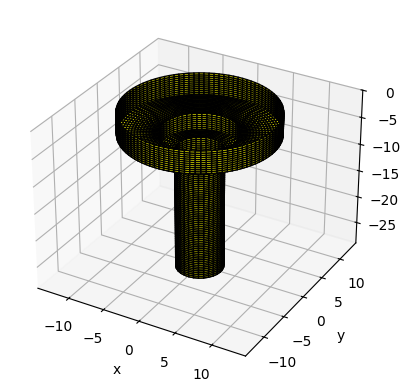

[15:26:27] WARNING  Irregular frequencies for RadiationProblem(body=FloatingBody(...,                              
                    name="collection_of_meshes_68"), wavenumber=1.000, water_depth=100.0, radiating_dof='Heave',   
                    rho=1023.0):                                                                                   
                    The body FloatingBody(..., name="collection_of_meshes_68") might display irregular frequencies 
                    for wavenumber=1.                                                                              
                    Setting a lid for the floating body is recommended.

[15:26:59] WARNING  Irregular frequencies for DiffractionProblem(body=FloatingBody(...,                            
                    name="collection_of_meshes_68"), wavenumber=1.000, water_depth=100.0, wave_direction=0.000,    
                    rho=1023.0):                                                                                   
                    The body FloatingBody(..., name="collection_of_meshes_68") might display irregular frequencies 
                    for wavenumber=1.                                                                              
                    Setting a lid for the floating body is recommended.

Panel Count:  5330
{'Heave': 1265181.8940941708}
{'Heave': 219.73629788683473}
Solve Time (Radiation):  31.280981249990873
Solve Time (Diffraction):  0.07843845800380222
Excitation Phase:  -2.963439272634363


In [10]:
#tall  - spar not heaving
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [0, 1, 1]
t_densities = [30, 50, 100]
face_units = 110
m0 = 1
rho = 1023
config = "config6"
reps = 1

result_r, solve_time_r, result_d, solve_time_d, panel_count_alt = construct_and_solve(a, d, heaving, t_densities, face_units, h, m0, rho, reps)

In [11]:
# Get potentials
# Define the ranges for R and Z
R_range = np.linspace(0.0, 2*a[-1], num=50)
theta_range = np.linspace(-np.pi, np.pi, num=4)
Z_range = np.linspace(0, -h, num=50) 

# Create mesh grids for R, theta, and Z
R, theta, Z = np.meshgrid(R_range, theta_range, Z_range, indexing='ij')

# Convert cylindrical coordinates to Cartesian coordinates for capytaine
X = R * np.cos(theta)
Y = R * np.sin(theta)
Z = Z
# Create an array of shape (N, 3)
points = np.zeros((R.size, 3))

# Assign the values of R, Z, and y to the array
points[:, 0] = X.ravel()
points[:, 1] = Y.ravel()
points[:, 2] = Z.ravel()
#need cartesian here
phi_inc = solver.compute_potential(points, result_r) #rad problem

regions = []
regions.append((R <= a[0]) & (Z > -d[0]))
for i in range(1, len(a)):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z > -d[i]))
regions.append(R > a[-1])

# Apply masks to create a blank plot in specified regions
phi_inc = phi_inc.reshape((50,4,50))

for i in range(len(a)):
  phi_inc[regions[i]] = np.nan



In [12]:
# Get velocities
vel_inc = solver.compute_velocity(points, result_r)
velx_inc = vel_inc[:,0].reshape((50,4,50))
vely_inc = vel_inc[:,1].reshape((50,4,50))
velz_inc = vel_inc[:,2].reshape((50,4,50))
for i in range(len(a)):
  velx_inc[regions[i]] = np.nan
  vely_inc[regions[i]] = np.nan
  velz_inc[regions[i]] = np.nan

/Users/hopebest/Documents/semi-analytical-hydro/.venv/lib/python3.12/site-packages/matplotlib/contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/Users/hopebest/Documents/semi-analytical-hydro/.venv/lib/python3.12/site-packages/matplotlib/contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/Users/hopebest/Documents/semi-analytical-hydro/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


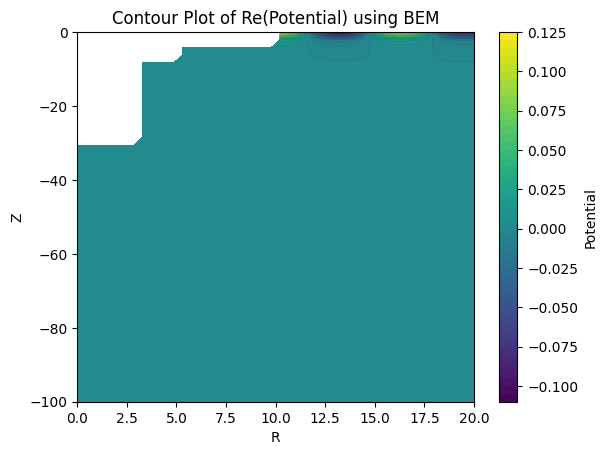

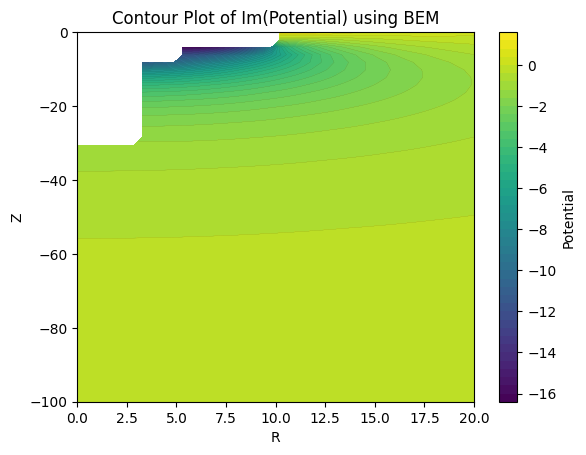

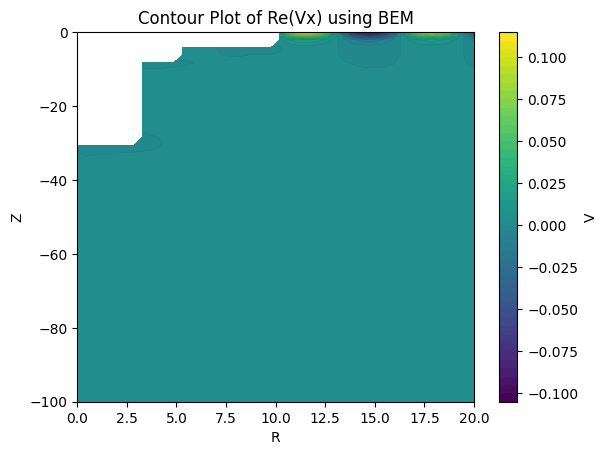

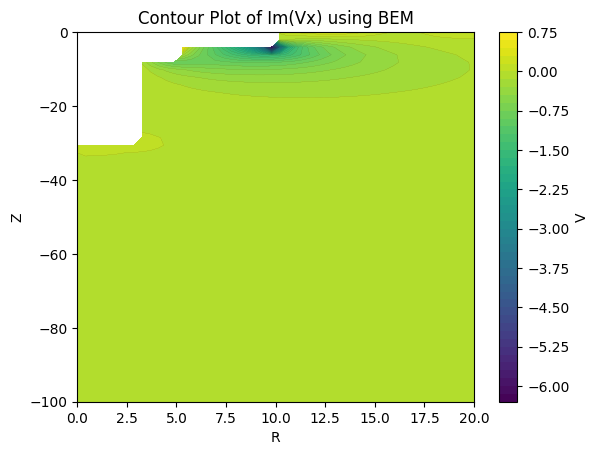

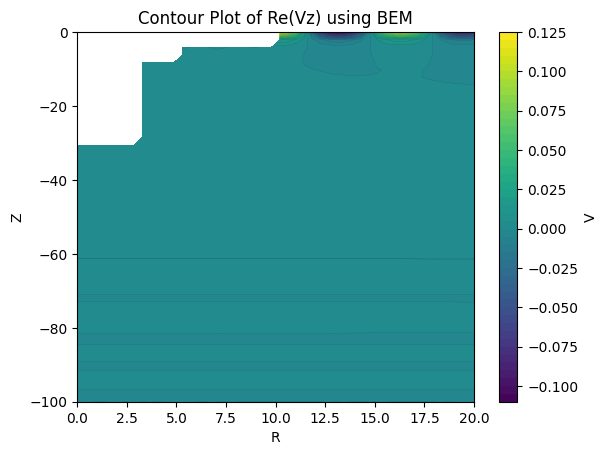

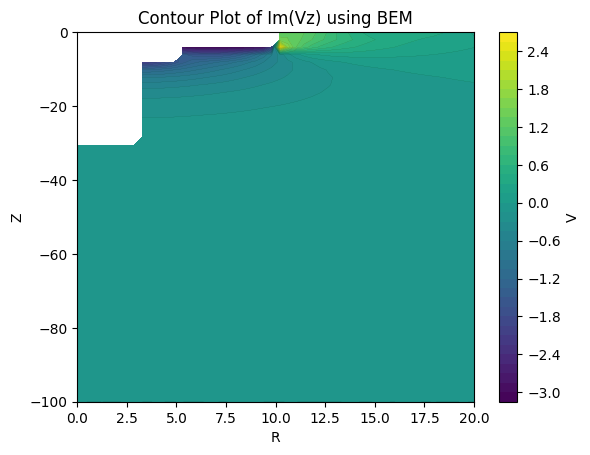

In [13]:
# Plot potentials and velocities
# The slicing limits the y-value to 0 because we only care about the x-z (r-z) plane.
plt.contourf(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], phi_inc[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Re(Potential) using BEM')

plt.show()

imag_phi_inc = np.imag(phi_inc[:, 0, :])

nan_mask = np.isnan(np.real(phi_inc[:, 0, :]))

np.imag(phi_inc[:, 0, :])[nan_mask] = np.nan

plt.contourf(R[:, 0, :], Z[:, 0, :], imag_phi_inc, cmap='viridis', levels = 50)
plt.colorbar(label='Potential')
plt.contour(R[:, 0, :], Z[:, 0, :], imag_phi_inc, colors='black', linestyles='solid', linewidths=0.05,levels=50)


# Add labels and title
plt.xlabel('R')
plt.ylabel('Z')
plt.title('Contour Plot of Im(Potential) using BEM')

plt.show()

def plot_vel(data, title):
  plt.contourf(R[:, 0, :], Z[:, 0, :], data[:, 0, :], cmap='viridis', levels = 50)
  plt.colorbar(label='V')
  plt.contour(R[:, 0, :], Z[:, 0, :], data[:, 0, :], colors='black', linestyles='solid', linewidths=0.05,levels=50)

  # Add labels and title
  plt.xlabel('R')
  plt.ylabel('Z')
  plt.title(title)

  plt.show()

nan_mask = np.isnan(np.real(velx_inc))

velx_imag = np.imag(velx_inc)
velz_imag = np.imag(velz_inc)

velx_imag[nan_mask] = np.nan
velz_imag[nan_mask] = np.nan

plot_vel(velx_inc, "Contour Plot of Re(Vx) using BEM")
plot_vel(velx_imag, "Contour Plot of Im(Vx) using BEM")
plot_vel(velz_inc, "Contour Plot of Re(Vz) using BEM")
plot_vel(velz_imag, "Contour Plot of Im(Vz) using BEM")


In [14]:
save_potential_array(config, phi_inc[:, 0, :])
# WARNING: This overwrites existing files with the same name. Ensure that <config> is correct before running.